In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras import regularizers
from IPython.display import Image

In [ ]:
! zip -r /content/drive/MyDrive/Combined_Dataset.zip /content/AIRecognition
dataset_dir = "/content/AIRecognition"

Data loading and pre-processing (splitting data, image labelling, data augmentation techniques)

In [ ]:
img_height = 224
img_width = 224
batch_size = 100

# Load the training data
train_ds = tf.keras.utils.image_dataset_from_directory(
  dataset_dir,
  validation_split=0.2, # split the dataset into 80% for training and 20% for validation
  shuffle=True,
  subset="training",
  seed = 512,
  image_size = (img_height, img_width),
  batch_size = batch_size)

# Load the validation data
val_ds = tf.keras.utils.image_dataset_from_directory(
  dataset_dir,
  validation_split=0.2,
  subset="validation",
  seed = 512,
  image_size = (img_height, img_width),
  batch_size = batch_size)

data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal_and_vertical"),  # Randomly flip images horizontally and vertically
    RandomRotation(0.2),  # Randomly rotate images by 20%
    RandomZoom(0.2),  # Randomly zoom into images
    RandomContrast(0.2)  # Randomly adjust contrast
])

# apply augmentation to training data
augmented_train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))  

class_names = train_ds.class_names

Found 27548 files belonging to 2 classes.
Using 22039 files for training.
Found 27548 files belonging to 2 classes.
Using 5509 files for validation.


Model Architecture Definition

In [ ]:
# Load pre-trained model
ResNet_base_model = tf.keras.applications.ResNet50(
    include_top = False,
    weights = 'imagenet',
    input_shape = (img_height, img_width, 3)
)
# Allow model weights to be trained
ResNet_base_model.trainable = True

# Create a new model on top of the ResNet50 base model
inputs = tf.keras.Input(shape = (img_height, img_width, 3))
x = ResNet_base_model(inputs, training = False)
x = GlobalAveragePooling2D()(x)
outputs = Dense(1, activation = 'sigmoid')(x)
ResNet_model = tf.keras.Model(inputs, outputs)

# Compile the model
ResNet_model.compile(
    optimizer = tf.keras.optimizers.Adamax(learning_rate = 0.001),  # Adamax Optimizer with a learning rate of 0.001
    loss = tf.keras.losses.BinaryCrossentropy(),    # Binary cross entropy loss
    metrics = ['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()] # Added accuracy, precision and recall for evaluation metrics
)

ResNet_model.summary()

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_22 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_1  (None, 2048)              0         
 0 (GlobalAveragePooling2D)                                      
                                                                 
 dense_10 (Dense)            (None, 1)                 2049      
                                                                 
Total params: 23589761 (89.99 MB)
Trainable params: 23536641 (89.79 MB)
Non-trainable params: 53120 (207.50 KB)
_________________________________________________________________


Model Training

In [ ]:
# Early stop in training if no improvement in loss over 10 epochs
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 10, restore_best_weights = True)

# Train model
ResNet_model_history = ResNet_model.fit(
    augmented_train_ds,
    validation_data = val_ds,
    epochs = 100,
    verbose = 1,
    callbacks = [early_stopping]
)

# Save model weights
ResNet_model.save('resnet_base_model')

Epoch 1/100
221/221 [==============================] - 548s 2s/step - loss: 1.2235 - accuracy: 0.7793 - precision_10: 0.7490 - recall_10: 0.5612 - val_loss: 0.3097 - val_accuracy: 0.8778 - val_precision_10: 0.9186 - val_recall_10: 0.7183
Epoch 2/100
221/221 [==============================] - 513s 2s/step - loss: 0.2916 - accuracy: 0.8834 - precision_10: 0.8613 - recall_10: 0.7971 - val_loss: 0.2339 - val_accuracy: 0.9083 - val_precision_10: 0.9002 - val_recall_10: 0.8332
Epoch 3/100
221/221 [==============================] - 518s 2s/step - loss: 0.2253 - accuracy: 0.9110 - precision_10: 0.8965 - recall_10: 0.8448 - val_loss: 0.1928 - val_accuracy: 0.9256 - val_precision_10: 0.9513 - val_recall_10: 0.8322
Epoch 4/100
221/221 [==============================] - 518s 2s/step - loss: 0.1954 - accuracy: 0.9233 - precision_10: 0.9098 - recall_10: 0.8682 - val_loss: 0.2107 - val_accuracy: 0.9234 - val_precision_10: 0.9775 - val_recall_10: 0.8019
Epoch 5/100
221/221 [===========================

Evaluation Metrics

In [ ]:
# Test model on validation set and get evaluation metrics
val_loss, val_accuracy, val_precision, val_recall = ResNet_model.evaluate(val_ds)

# Print the metrics
print(f"Val Loss: {val_loss:.4f}")
print(f"Val Accuracy: {val_accuracy:.4f}")
print(f"Val Precision: {val_precision:.4f}")
print(f"Val Recall: {val_recall:.4f}")

56/56 [==============================] - 94s 1s/step - loss: 0.1497 - accuracy: 0.9461 - precision_10: 0.9412 - recall_10: 0.9041
Val Loss: 0.1497
Val Accuracy: 0.9461
Val Precision: 0.9412
Val Recall: 0.9041


Plot Metrics (Accuracy and Loss)

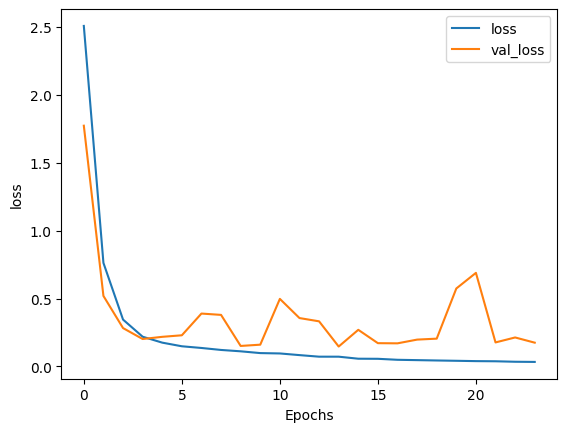

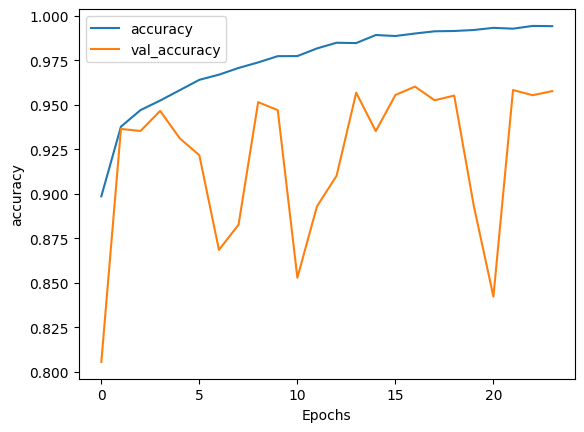

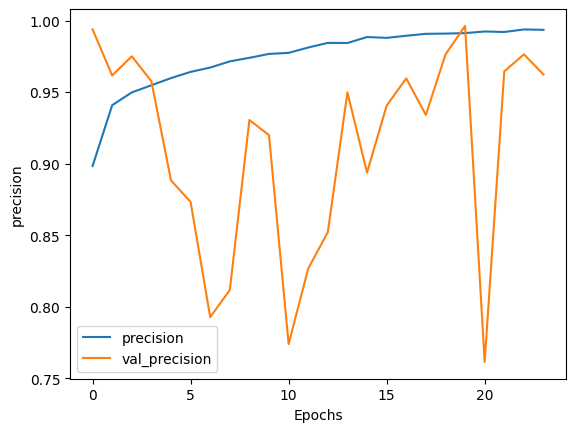

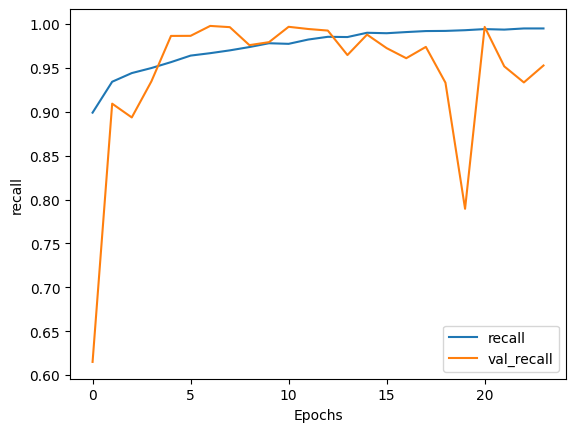

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# Plot model accuracy and loss history for training and validation dataset
def plot_metrics(history, metric):
    plt.plot(history.history[metric], label = metric)
    plt.plot(history.history['val_' + metric], label='val_' + metric)
    plt.xlabel('Epochs')
    plt.ylabel(metric)
    plt.legend()
    plt.show()
    
plot_metrics(ResNet_model_history, 'loss')
plot_metrics(ResNet_model_history, 'accuracy')